# **Lab 10 - Explainable and Trustworthy AI**


---



**Teacher**: Eliana Pastor (eliana.pastor@polito.it)


---

## **Counterfactual explanatios**

We generate counterfactual of individual predictions provided.
We consider the [DICE](https://dl.acm.org/doi/10.1145/3351095.3372850) algorithm and the [dice-ml](https://interpret.ml/DiCE/) library.
Part of this laboratory is adapted from the official examples of the library. You can refer to the original notebook examples from full details on the library and its usage.


We focus on the [Adult dataset](https://archive.ics.uci.edu/dataset/2/adult) and a Random Forest classifier, as done for the previous labs (e.g., 3b and 7a).

> **Dataset.** The Adult dataset, also known as the "Census Income" dataset, contains demographic information about people, such as age, education, occupation, marital status and more, extracted from the 1994 U.S. Census Bureau database. **Each entry** in the dataset represents a **person**, and the associated **task** is to **predict whether an individual earns more than $50,000 per year** or less.

> **Model**

* We first load the Adult dataset.
  * We can directly [load the dataset from UCI](https://archive.ics.uci.edu/dataset/2/adult) and process it. The dataset is available from the UCI repository. Using the library ucimlrepo we can easily fetch the dataset. Alternatively, we can use the dataset available in the SHAP [library](https://shap.readthedocs.io/en/latest/generated/shap.datasets.adult.html) as done for the previous labs.
  Or w
*  We split the Adult dataset. 80/20 train-test ratio.
*  We then rain a RandomForestClassifier and fit it over the training dataset. Evaluate the model.


> **Counterfactual Explanations**

Use the algorithm DICE to generate counterfactual.

1. Generate counterfarfactuals for the instance `id=0` of the test set using defaul parameters.
2. Generate counterfarfactuals imposing a actionability constraint. Specify the set of attributes to be modified to generate the counterfactuals.
3. Generate counterfarfactuals imposing a feasibility constraints. Specify the range of values of the features.
4. DICE computes a feature importance considering the number of times a feature is changed to generate a counterfactual.
The more ofter a feature is changed, the more it is important to generate the counterfactuals.

In [ ]:
! pip install ucimlrepo

In [ ]:
!pip install dice-ml

In [1]:
%load_ext autoreload
%autoreload 2

# Data import, processing and training

In the following, first load the data, preprocess it and train a Random Forest classifier

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets.copy() 
y.replace({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)

In [4]:
attributes = list(X.columns)
target_class = list(y.columns)[0]

Split train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

Preprocessing

In [6]:
X.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
numerical = ['age', 'fnlwgt', 'hours-per-week', 'education-num', 'capital-gain', 'capital-loss']
categorical = X_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

In [8]:
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(X_train, y_train)

/Users/eliana/miniconda3/envs/xailab/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Counterfactual explanantions using DICE

Import DICE package

In [9]:
import dice_ml

In [10]:
# Provide the trained model to DiCE's model object
# Note that we specify tha the model is a sklearn model
backend = 'sklearn'
m = dice_ml.Model(model=model, backend=backend)

In [38]:
df_data = X_train.copy()
df_data[target_class] = y_train.values

# Define the data to generate counterfactuals
# We specify the data (target class included), the continuous features and the target class

d = dice_ml.Data(dataframe=df_data, \
                 continuous_features=numerical, 
                 outcome_name=target_class)


DICE supports multiple algorithms to generate counterfactuals. We use the 'random' method based on random sampling of features

In [39]:
dice_alg = dice_ml.Dice(d, m, method="random")

## 1. Generate counterfactuals for a single instance

Select the instance for which we want to generate a counterfactual. 

We select the first instance of the test set

In [40]:
# Specify the query instance for which we want to generate the counterfactual
# Use the first instance of the test set
# We suggest to specify it as a pandas dataframe
query_instance = X_test[1:2]
query_instance

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
47738,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,39,United-States


What is the original prediction for the query instance?

In [41]:
clf.predict(query_instance)

array(['<=50K'], dtype=object)

Generate 3 counterfactuals for the query instance

In [42]:
# Generate the counterfactuals
dice_exp = dice_alg.generate_counterfactuals(query_instance, 
                                             total_CFs=3, #Specify the number of counterfactuals to generate
                                             desired_class="opposite", # We want to generate counterfactuals that will have as predicted class the opposite of the original instance
                                             verbose=False, 
                                             random_seed=7)

100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


You can visualize the counterfactuals using the visualize_as_dataframe method. This method will return a pandas dataframe with the counterfactuals generated.

By setting show_only_changes=True, it will generate a sparse visualization of the counterfactuals, were only the changed features and values are reported

In [43]:
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : <=50K)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,39,United-States,<=50K



Diverse Counterfactual set (new outcome: >50K)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,-,-,-,-,-,-,37002,-,-,-,>50K
1,-,-,-,-,-,-,-,-,-,-,72141,1270,-,-,>50K
2,-,-,-,-,-,-,-,-,-,-,-,3740,-,-,-


Get the counterfactuals as a dataframe

In [44]:
counterfactuals_df = dice_exp.cf_examples_list[0].final_cfs_df
counterfactuals_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,37002,0,39,United-States,>50K
1,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,72141,1270,39,United-States,>50K
2,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,0,3740,39,United-States,<=50K


Check that indeed the model predicts the opposite class for the counterfactuals

In [45]:
clf.predict(counterfactuals_df[attributes])

array(['>50K', '>50K', '<=50K'], dtype=object)

## 2. Actionable Counterfactuals

Goal: Generate counterfarfactuals imposing a actionability constraint.
We specify the set of attributes to be modified to generate the counterfactuals.

Depending on the data and task, it is not always possible to modify some attributes.append
For example, if we want to generate a counterfactual for a person with a certain age, we cannot change the age of the person. 
In this case, we can specify the attributes that we want to keep fixed using the features_to_vary parameter.

We can use the parameter `features_to_vary` to specify the features that we want to vary

In [53]:
# generate counterfactuals
dice_exp = dice_alg.generate_counterfactuals(
        query_instance, 
        total_CFs=2, #Specify the number of counterfactuals to generate
        desired_class="opposite",
        features_to_vary=["workclass", "fnlwgt", "occupation", "hours-per-week"], #Specify the features to vary
        random_seed=7)

100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


In [54]:
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : <=50K)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,39,United-States,<=50K



Diverse Counterfactual set (new outcome: >50K)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,Private,-,-,-,-,Exec-managerial,-,-,-,-,-,-,-,>50K
1,-,Private,-,-,-,-,Exec-managerial,-,-,-,-,-,-,-,>50K


## 3. Feasible Counterfactuals

Generate counterfarfactuals imposing a feasibility constraints. 
In generate counterfactuals, we should also consider the range the feature values can assume.
For example, we cannot increase indiscriminately the number of hours per week or the age range. 

In DICE, we specify the admitted range of values of the features.

We can use the parameter `permitted_range` to specify the range admitted for set of features. We specify the permitted range as a dictionary: {'attribute_name' :  [min_value, max_value], ..}

In [57]:
# generate counterfactuals
dice_exp = dice_alg.generate_counterfactuals(
    query_instance, 
    total_CFs=5, # Specify the number of counterfactuals to generate
    desired_class="opposite", 
    permitted_range={'age': [22, 50], 'hours-per-week': [40, 60]}) # Specify the permitted range for the features as a dictionary : {feature_name: [min_value, max_value], ..}

100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


In [58]:
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : <=50K)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,54,State-gov,55861,Assoc-acdm,12,Divorced,Adm-clerical,Not-in-family,White,Male,0,0,39,United-States,<=50K



Diverse Counterfactual set (new outcome: >50K)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,-,-,-,-,-,-,-,-,-,-,-,3787,-,-,-
1,-,-,-,-,-,-,-,-,-,-,75190,-,-,-,>50K
2,-,-,-,-,-,-,-,-,Black,-,53348,-,-,-,>50K
3,-,-,-,-,-,-,-,-,-,-,48452,-,-,Canada,>50K
4,-,-,-,-,-,-,-,-,-,-,60569,-,49,-,>50K


## 4. Feature importance for the counterfactuals

DICE computes a feature importance considering the number of times a feature is changed to generate a counterfactual.
The more ofter a feature is changed, the more it is important to generate the counterfactuals.

For the computation of feature importance we use the method `local_feature_importance`.
The method needs a set of counterfactuals (minimum 10) generated for the same query instance and computes the feature importance.

In [60]:
# Generate the counterfactuals
dice_exp = dice_alg.generate_counterfactuals(query_instance, 
                                             total_CFs=20, #Specify the number of counterfactuals to generate (>10)
                                             desired_class="opposite", # We want to generate counterfactuals that will have as predicted class the opposite of the original instance
                                             verbose=False, 
                                             random_seed=7)

100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


In [64]:
# Generate the feature importance
 
dice_exp_loc_imp = dice_alg.local_feature_importance(query_instance, 
                                             cf_examples_list=dice_exp.cf_examples_list)

In [66]:
# Print the local feature impornance
 
print(dice_exp_loc_imp.local_importance)

[{'capital-gain': 0.65, 'capital-loss': 0.4, 'fnlwgt': 0.1, 'workclass': 0.05, 'marital-status': 0.05, 'occupation': 0.05, 'race': 0.05, 'age': 0.05, 'education-num': 0.05, 'education': 0.0, 'relationship': 0.0, 'sex': 0.0, 'native-country': 0.0, 'hours-per-week': 0.0}]


Plot the local feature importance as a bar chart

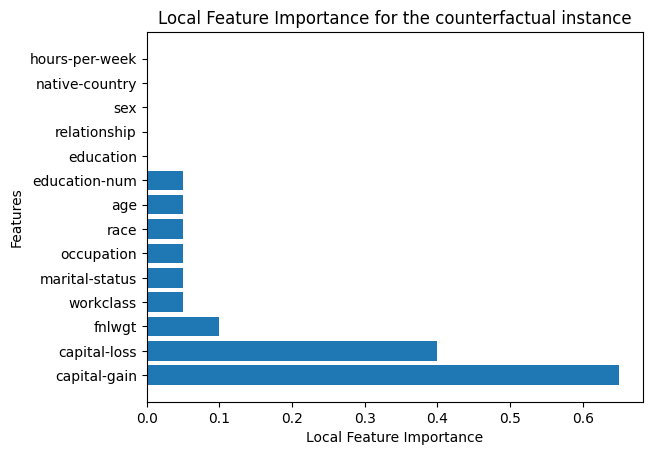

In [68]:
import matplotlib.pyplot as plt

features_list = list(dice_exp_loc_imp.local_importance[0].keys())
importance_values = list(dice_exp_loc_imp.local_importance[0].values())
plt.barh(features_list, importance_values) 
plt.xlabel('Local Feature Importance')
plt.ylabel('Features')
plt.title('Local Feature Importance for the counterfactual instance');